### Import Packages

In [1]:
from collections import defaultdict
import json
import multiprocessing as mp
import os
import random
import sys

In [2]:
import cv2
from icecream import ic
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
from pycocotools.coco import COCO
import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

In [3]:
sys.path.append('../dataset/')
import coco_api_helper
import coco_data_prep
import config_dataset

loading annotations into memory...
Done (t=12.19s)
creating index...
index created!
loading annotations into memory...
Done (t=6.58s)
creating index...
index created!
loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


### Global Variables

In [4]:
train_jpg_data_dir = '../data/raw/train/train2014/'
train_np_data_dir = '../data/numpy_imgs/train_subset/'
train_annot_path = '../data/raw/train/annotations/instances_train2014.json'

In [5]:
os.listdir(train_np_data_dir)[:3]

['COCO_train2014_000000183202.np',
 'COCO_train2014_000000440546.np',
 'COCO_train2014_000000081323.np']

In [6]:
annot_filepaths = {'train': config_dataset.train_annotation_filepath,
                 'validation' : config_dataset.valid_annotation_filepath,
                 'test': config_dataset.test_annotation_filepath}

In [7]:
with open ('../dataset/categories.json', 'r') as j:
    desired_categories = json.load(j)
    
with open ('../dataset/imgs_by_supercategory.json', 'r') as f:
    imgid_by_supercat = json.load(f)
    
# flatten to a list of imgids
desired_img_ids = list(set([ii for img_id in list(imgid_by_supercat.values()) for ii in img_id]))
len(desired_img_ids)

43266

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Dataset & DataLoader

In [9]:
class COCODataset(Dataset):
    def __init__(self,
                 np_img_data_dir,
                 annot_filepath,
                 sample_ratio: float = None,
                 device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
        """
        :np_img_data_dir: local directory where you have unzipped np files saved 
            np files are the trasnformed images from s3 that were normalized/ resized/ padded
        :annot_filepath: filepath of the original coco dataset corresponding to the datasplit of your choosing
        :sample_ratio: specified float between 0 and 1 for the % of images from the data split you want to use
        :device: cpu or gpu
        """
        self.device = device
        self.np_img_data_dir = np_img_data_dir

        self.sample_ratio = sample_ratio
        self.coco = COCO(annot_filepath)

        # All possible image ids
        all_train_img_ids = list(self.coco.imgs.keys())
        # Filter down to the image ids applicable to our supercategories
        self.ids = [ii for ii in tqdm(all_train_img_ids) if ii in desired_img_ids]

        if self.sample_ratio is None:
            pass
        else:
            self.ids = list(np.random.choice(self.ids, int(self.sample_ratio * len(all_train_img_ids))))

    def __getitem__(self, index):
        coco = self.coco

        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=[img_id])
        target = coco.loadAnns(ann_ids)

        path = coco.loadImgs([img_id])[0]['file_name']
        np_path = path.split('.')[0] + '.np'
        img = np.load(os.path.join(self.np_img_data_dir, np_path))
        
        # Convert the image to tensor so it's compatible w/ pytorch data loader
        img = torch.Tensor(img.transpose(2,0,1)).to(device=self.device).float()

        return img, target

    def __len__(self):
        return len(self.ids)
    
    
def get_dataloader(dataset_obj,
                   batch_size: int=100,
                   device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
                   loader_params:dict = config_dataset.dataloader_params):
    """Returns data loader for custom dataset.
    Args:
        :dataset_obj: dataset object returned from COCODataset class
        :batch_size: specified batch size, if you have memory errors while running, make this smaller
        :device: default is CUDA if there is GPU otherwise CPU
        :loader_params: default is found in config_dataset.py's dataloader_params dict
            can specify your own data loader params, but collate_fn must be `lambda x: x`
            specify:
                shuffle: True / False
                num_workers: number of parallel processes to run
                collate_fn: lambda x: x
    Returns:
        data_loader: data loader for COCODataset.
    """
    # data loader for custom dataset
    # this will return (imgs, targets) for each iteration
    loader_params.update({'batch_size': batch_size})
    
    data_loader = DataLoader(
        dataset=dataset_obj, 
        **loader_params,
    )
    return data_loader

### Initializing `COCODataset`
- `COCODataset` inherits from torch.utils.data.Dataset and requires a `__len__` and `__getitem__`.
- This is a map style [Dataset](https://pytorch.org/docs/stable/data.html#dataset-types).
- This is inspired by PyTorch's [COCODetection](https://pytorch.org/docs/0.4.0/_modules/torchvision/datasets/coco.html): 

- pass in the numpy data directory (`np_img_data_dir`) where np images are stored
- pass in `annot_filepath` which is the relative filepath of where the annotation file. This is needed in order to check what objects are in the image, which will help us evaluate how effective our CBIR algorithm is    
- pass in the `sample_ratio` argument
    - The sample ratio argument is to stipulate the % of the total images in the stipulated data directory that you wish to use for training your model. For example if there are a total of 80K+ images in the data directory, stipulating 5% will randomly select approximately 4K+ images from the data directory to write to the torch.utils.data.Dataset object (`COCODataset`)
    - In randomly sampling, the corresponding CORRECT targets will be retrieved for the randomly sampled images

In [10]:
train_ds_play = COCODataset(train_np_data_dir, 
                            train_annot_path,
                            0.01, 
                            device='cpu')

loading annotations into memory...
Done (t=12.97s)
creating index...
index created!


100%|████████████████████████████████████████████████████████| 82783/82783 [00:48<00:00, 1701.92it/s]


### DataLoader
- when calling Dataloader, pass in your specific DataLoader arguments
    - `train_dataset` : `Dataset` object
    - `batch_size` : This is the stipulated batch size (lower this in the event you run into memory errors during training).
    - `shuffle = False` is a better DataLoader param if you stipulated a `sample_ratio` in the initialization of `COCODataset`.
    - `num_workers=mp.cpu_count()` is if you are running the process on the CPU instead of GPU otherwise stipulate number of GPUs. 
    - `collate_fn` MUST BE `lambda x: x` otherwise the data loader WILL NOT work. This allows for the targets to load properly, otherwise it will not load correctly. DEFINITELY DO THIS WHEN LOADING DATA

In [11]:
train_dl_play = get_dataloader(train_ds_play, batch_size=100, device='cpu')

In [12]:
ann_ids = train_ds_play.coco.getAnnIds(imgIds=[137386])
target = train_ds_play.coco.loadAnns(ann_ids)[0]

In [13]:
for i, batch in tqdm(enumerate(train_dl_play)):
    image_batch, label_batch = [x[0] for x in batch], [x[1] for x in batch]  
    image_batch = torch.stack(image_batch).to(device)

9it [00:04,  2.15it/s]


### Accessing One Image at a Time
- because the `Dataset` object has the `__getitem__` method, you need only give the dataset object an index, to specify which image you'd like to inspect 

In [14]:
# get the 0'th image from the dataset 

print(train_ds_play[0][0]) # <-- the image
print(train_ds_play[0][1]) # <-- the target

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [15]:
print(type(train_ds_play[0][0]))
print(train_ds_play[0][0].shape)

<class 'torch.Tensor'>
torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


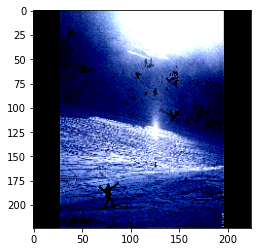

In [16]:
plt.imshow(train_ds_play[0][0].numpy().transpose((1,2,0)))